In [1]:
import pandas as pd
import os
from Bio import SeqIO
species = ['human', 'worm', 'yeast', 'zebrafish']
anno_file_path = "~/database/uniprot/swiss/metal_anno"
fasta_file_path = "~/database/uniprot/fasta"

In [2]:
def get_all_proteins(fasta_file):
    uniprots = set()
    fasta_file = os.path.expanduser(fasta_file)
    for r in SeqIO.parse(fasta_file, "fasta"):
        uniprots.add(r.id.split("|")[1])
    return uniprots

def get_anno_proteins(df):
    return set(df['uniprot'])

def get_anno_residues(df):
    return set(zip(df['uniprot'], df['resi'], df['resi_seq_num']))

def get_pred_proteins(df):
    return set(df['seq_id'])

def get_pred_residues(df):
    residues = set()
    for _, row in df.iterrows():
        resi_1, resi_seq_posi_1 = row['resi_1'], row['resi_seq_posi_1']
        resi_2, resi_seq_posi_2 = row['resi_2'], row['resi_seq_posi_2']
        seq_id = row['seq_id']
        
        residues.add((seq_id, resi_1, resi_seq_posi_1 + 1))
        residues.add((seq_id, resi_2, resi_seq_posi_2 + 1))
    return residues


def calc_metrics_for_species(fasta_file, pred_file, anno_file):
    all_proteins = get_all_proteins(fasta_file)
    
    df_pred = pd.read_csv(pred_file, sep="\t")
    df_pred = df_pred[df_pred['filter_by_graph'] == 1]
    df_pred = df_pred[df_pred['seq_id'].map(lambda x: x in all_proteins)]
    df_anno = pd.read_csv(anno_file, sep="\t")
    df_anno = df_anno[df_anno['uniprot'].map(lambda x: x in all_proteins)]
    
    mbps_anno = get_anno_proteins(df_anno)
    mbps_pred = get_pred_proteins(df_pred)
    residues_anno = get_anno_residues(df_anno)
    residues_pred = get_pred_residues(df_pred)
    
    resi_inter = residues_anno & residues_pred
    mbps_inter = set([i[0] for i in resi_inter]) # at least one common residue
    
    return {
        "Predicted by Metalnet": len(mbps_pred) / len(all_proteins),
        "Annotated by Uniprot": len(mbps_anno) / len(all_proteins),
        "Intersection": len(mbps_inter) / len(all_proteins)
    }

In [3]:
pc_anno = []
pc_pred = []
pc_inter = []
for s in species:
    m = calc_metrics_for_species(
        fasta_file=f"{fasta_file_path}/{s}.fasta", # from https://www.uniprot.org/proteomes
        pred_file=f"../{s}_pred_mbps.tsv", 
        anno_file=f"{anno_file_path}/{s}_metal_anno.csv")
    pc_anno.append(m['Annotated by Uniprot'])
    pc_pred.append(m['Predicted by Metalnet'])
    pc_inter.append(m['Intersection'])
    print(s)
    print(m)

human
{'Predicted by Metalnet': 0.22869911590401243, 'Annotated by Uniprot': 0.09530749052754299, 'Intersection': 0.06640435247255416}
worm
{'Predicted by Metalnet': 0.17143289453775154, 'Annotated by Uniprot': 0.024965955515206535, 'Intersection': 0.01795531346144147}
yeast
{'Predicted by Metalnet': 0.19323432343234323, 'Annotated by Uniprot': 0.07953795379537953, 'Intersection': 0.05396039603960396}
zebrafish
{'Predicted by Metalnet': 0.1952836298525658, 'Annotated by Uniprot': 0.020572212274753324, 'Intersection': 0.014933902243895006}


Text(0, 0.5, 'Fraction of proteins in proteome')

Text(0.5, 0, 'Species')

<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

([<matplotlib.axis.XTick at 0x7fa95f010fa0>,
 [Text(0, 0, 'human'),
  Text(1, 0, 'worm'),
  Text(2, 0, 'yeast'),
  Text(3, 0, 'zebrafish')])

([<matplotlib.axis.YTick at 0x7fa95f025ca0>,
 [Text(0, 0.0, '0.0'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4')])

(0.0, 0.4)

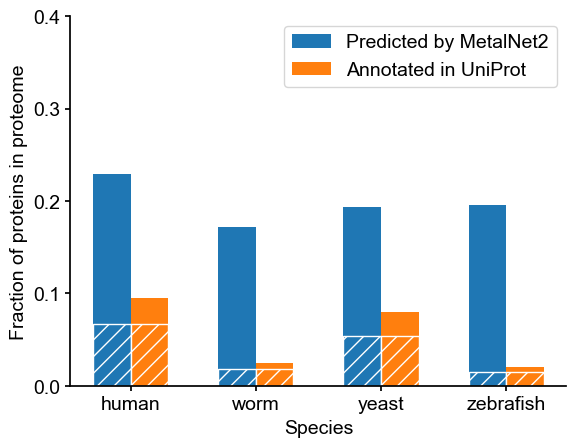

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use(f"{PROJECT_DIR}/asset/metalnet.mplstyle")

plt.ylabel("Fraction of proteins in proteome")
plt.xlabel("Species")

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
coor_x = np.arange(len(species))
width = 0.3
plt.bar(coor_x - width / 2, pc_pred, width=width)
plt.bar(coor_x + width / 2, pc_anno, width=width)

plt.bar(coor_x - width / 2, pc_inter, width=width, alpha=1, hatch='//', edgecolor="white", color="#1f77b4")
plt.bar(coor_x + width / 2, pc_inter, width=width, alpha=1, hatch='//', edgecolor="white", color='#ff7f0e')
plt.xticks(coor_x, labels=species)
plt.yticks(np.arange(0, 0.5, 0.1))
plt.ylim(bottom=0, top=0.4)

plt.legend(labels=['Predicted by MetalNet2',
                   'Annotated in UniProt'],
           loc='upper right',
           bbox_to_anchor=(1,1))
plt.savefig("./fig/comparison_anno_pred.pdf", bbox_inches="tight", transparent=True)

## updated result for prokaryotic species

In [4]:
species = ['ecoli', 'bacsu', 'sacs2', 'halsa']
pred_file_path = "~/database/metalnet/prediction/"

pc_anno = []
pc_pred = []
pc_inter = []
for s in species:
    m = calc_metrics_for_species(
        fasta_file=f"{fasta_file_path}/{s}.fasta", # from https://www.uniprot.org/proteomes
        pred_file=f"{pred_file_path}/{s}_pred_pairs.tsv", 
        anno_file=f"{anno_file_path}/{s}_metal_anno.csv")
    pc_anno.append(m['Annotated by Uniprot'])
    pc_pred.append(m['Predicted by Metalnet'])
    pc_inter.append(m['Intersection'])
    print(s)
    print(m)

/tmp/ipykernel_23483/4262706507.py:32: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pred = pd.read_csv(pred_file, sep="\t")


ecoli
{'Predicted by Metalnet': 0.2502838973427209, 'Annotated by Uniprot': 0.1287758346581876, 'Intersection': 0.10084033613445378}


/tmp/ipykernel_23483/4262706507.py:32: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pred = pd.read_csv(pred_file, sep="\t")


bacsu
{'Predicted by Metalnet': 0.22793427230046948, 'Annotated by Uniprot': 0.09295774647887324, 'Intersection': 0.07183098591549296}
sacs2
{'Predicted by Metalnet': 0.2863466121893088, 'Annotated by Uniprot': 0.052434456928838954, 'Intersection': 0.03881511746680286}
halsa
{'Predicted by Metalnet': 0.2752785802723896, 'Annotated by Uniprot': 0.053652496904663644, 'Intersection': 0.041271151465125874}


/tmp/ipykernel_23483/4262706507.py:32: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pred = pd.read_csv(pred_file, sep="\t")


Text(0, 0.5, 'Fraction of proteins in proteome')

Text(0.5, 0, 'Species')

<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

([<matplotlib.axis.XTick at 0x7f3c290cc160>,
 [Text(0, 0, 'ecoli'),
  Text(1, 0, 'bacsu'),
  Text(2, 0, 'sacs2'),
  Text(3, 0, 'halsa')])

([<matplotlib.axis.YTick at 0x7f3c290cce20>,
 [Text(0, 0.0, '0.0'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4')])

(0.0, 0.4)

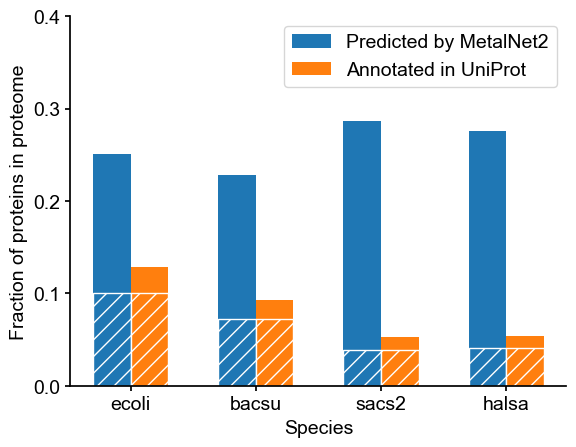

In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use(f"{PROJECT_DIR}/asset/metalnet.mplstyle")

plt.ylabel("Fraction of proteins in proteome")
plt.xlabel("Species")

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
coor_x = np.arange(len(species))
width = 0.3
plt.bar(coor_x - width / 2, pc_pred, width=width)
plt.bar(coor_x + width / 2, pc_anno, width=width)

plt.bar(coor_x - width / 2, pc_inter, width=width, alpha=1, hatch='//', edgecolor="white", color="#1f77b4")
plt.bar(coor_x + width / 2, pc_inter, width=width, alpha=1, hatch='//', edgecolor="white", color='#ff7f0e')
plt.xticks(coor_x, labels=species)
plt.yticks(np.arange(0, 0.5, 0.1))
plt.ylim(bottom=0, top=0.4)

plt.legend(labels=['Predicted by MetalNet2',
                   'Annotated in UniProt'],
           loc='upper right',
           bbox_to_anchor=(1,1))
plt.savefig("./fig/comparison_anno_pred_prokaryotes.pdf", bbox_inches="tight", transparent=True)